<a href="https://colab.research.google.com/github/assemzh/ProbProg-COVID-19/blob/master/virus_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epidemiology model

https://nbviewer.jupyter.org/github/pyro-ppl/pyro/blob/sir-tutorial-ii/tutorial/source/epi_regional.ipynb?fbclid=IwAR3Gv8tLuiEjOmZh7-NQUa_ggm_QUqtSc5TxRZ0_pSxVA7Y3lWWzSFGKjrA 


In [62]:
!git clone https://github.com/pyro-ppl/pyro.git

fatal: destination path 'pyro' already exists and is not an empty directory.


In [63]:
%cd /content/pyro

/content/pyro


In [64]:
!pip install .[extras]

Processing /content/pyro
  Created wheel for pyro-ppl: filename=pyro_ppl-1.5.0+634fe2d6-cp36-none-any.whl size=605432 sha256=d54a2a5e54e90faa3ccab3a4a060084e4f245b903b22bc3ef05c05ffddaa998d
  Stored in directory: /tmp/pip-ephem-wheel-cache-kzr2xwjd/wheels/7f/c8/0f/f4e71d6e55e68c8a64c8382f3f6eb829e6aa18323499202e37
Successfully built pyro-ppl
  Found existing installation: pyro-ppl 1.5.0+634fe2d6
    Uninstalling pyro-ppl-1.5.0+634fe2d6:
      Successfully uninstalled pyro-ppl-1.5.0+634fe2d6


In [65]:
import os
import logging
import urllib.request
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist
from pyro.ops.tensor_utils import convolve

%matplotlib inline
pyro.enable_validation(True)           
torch.set_default_dtype(torch.double) 


  ## Model without Policies
  

In [66]:
class CovidModel(CompartmentalModel):
    def __init__(self, population, new_cases, new_recovered, new_deaths):
        '''
        population (int) – Total population = S + E + I + R.
        '''
        assert len(new_cases) == len(new_recovered) == len(new_deaths)

        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(new_cases)
        super().__init__(compartments, duration, population)

        self.new_cases = new_cases
        self.new_deaths = new_deaths
        self.new_recovered = new_recovered
        

    def global_model(self):
        tau_e = pyro.sample("rec_time",dist.Normal(15.0, 1))
        tau_i = pyro.sample("incub_time",dist.Normal(5.0, 1))
        # R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        R0 = pyro.sample("R0", dist.Normal(2, 0.5))
        rho = pyro.sample("rho", dist.Beta(10, 10))  # About 50% response rate.
        mort_rate = pyro.sample("mort_rate", dist.Beta(2, 100))  # About 2% mortality rate.
        rec_rate = pyro.sample("rec_rate",dist.Beta(10, 10)) # About 50% recovery rate.
        return R0, tau_e, tau_i, rho, mort_rate, rec_rate

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho, mort_rate, rec_rate = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                            infection_dist(individual_rate=R0 / tau_i,
                                          num_susceptible=state["S"],
                                          num_infectious=state["I"],
                                          population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                            binomial_dist(state["E"], 1 / tau_e )) 
        I2R = pyro.sample("I2R_{}".format(t),
                            binomial_dist(state["I"], 1 / tau_i))
 
        # Update compartments with flows.
        state["S"] = state["S"] - S2E 
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("new_cases_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.new_cases[t] if t_is_observed else None)
        pyro.sample("new_deaths_{}".format(t),
                      binomial_dist(I2R, mort_rate),
                      obs=self.new_deaths[t] if t_is_observed else None)
        pyro.sample("new_recovered_{}".format(t),
                    binomial_dist(E2I, rec_rate),
                    obs=self.new_recovered[t] if t_is_observed else None)


## Create Country

In [67]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country (country, start_date, end_date, state = False) : 

    url = 'https://raw.githubusercontent.com/assemzh/ProbProg-COVID-19/master/full_grouped.csv'
    data = pd.read_csv(url)

    data.Date = pd.to_datetime(data.Date)

    if state :
        df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered", "Active", "New cases", "New deaths", "New recovered"]]
    else : 
        df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered", "Active", "New cases", "New deaths", "New recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered", "active", "new_cases", "new_deaths", "new_recovered"]

    # group by country and date
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered',"active", "new_cases", "new_deaths", "new_recovered"].sum().reset_index()

    # convert date string to datetime
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by = "date")
    df = df[df.date >= start_date]
    df = df[df.date <= end_date]

    active = df['active'].tolist()
    recovered = df['recovered'].tolist()
    deaths = df['deaths'].tolist()
    new_cases = df['new_cases'].tolist()
    new_recovered = df['new_recovered'].tolist()
    new_deaths = df['new_deaths'].tolist()
    
    active = torch.tensor(list(map(float, active))).view(len(active),1) 
    recovered = torch.tensor(list(map(float, recovered))).view(len(recovered),1) 
    deaths = torch.tensor(list(map(float, deaths))).view(len(deaths),1) 
    new_cases = torch.tensor(list(map(float, new_cases))).view(len(new_cases),1)  
    new_recovered = torch.tensor(list(map(float, new_recovered))).view(len(new_recovered),1) 
    new_deaths = torch.tensor(list(map(float, new_deaths))).view(len(new_deaths),1) 


    return_data = {
        'active':active,
        'recovered':recovered,
        'deaths':deaths,
        'new_cases':new_cases,
        'new_recovered': new_recovered,
        'new_deaths':new_deaths }
        
    return return_data


## Get data for countries


In [68]:
Japan = create_country("Japan", start_date = "2020-02-01", end_date = "2020-04-01")
Sweden = create_country("Sweden", start_date = "2020-02-01", end_date = "2020-04-01")
# print(India['new_cases'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


##Train the model using MCMC.



In [69]:
Japan_model = CovidModel(126500000, Japan["new_cases"], Japan["new_recovered"], Japan["new_deaths"] )

In [72]:
%%time
pyro.set_rng_seed(20200607)
Japan_mcmc = Japan_model.fit_mcmc(num_samples=200)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [01:43,  3.85it/s, step size=2.67e-03, acc. prob=0.883]

CPU times: user 1min 43s, sys: 371 ms, total: 1min 44s
Wall time: 1min 43s


In [74]:
Japan_mcmc.summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       rec_time     16.00      0.00     16.00     15.99     16.00      3.09      1.92
     incub_time      6.53      0.00      6.54      6.53      6.54      7.69      1.00
             R0      1.58      0.01      1.57      1.56      1.60      2.48      2.73
            rho      0.29      0.01      0.29      0.28      0.30      2.58      2.46
      mort_rate      0.02      0.00      0.02      0.02      0.02      2.50      2.79
       rec_rate      0.14      0.01      0.14      0.13      0.14      2.57      2.51
 auxiliary[0,0] 126499873.24      0.23 126499873.22 126499872.92 126499873.62      4.46      1.92
 auxiliary[0,1] 126499752.25      2.52 126499752.33 126499748.26 126499755.76      2.66      2.31
 auxiliary[0,2] 126499621.61      4.41 126499621.85 126499615.44 126499629.38      2.72      2.35
 auxiliary[0,3] 126499480.58      8.38 126499480.29 126499469.96 126499494.98      2.58      2.56
 auxi

In [79]:
Sweden_model = CovidModel(10230000, Sweden["new_cases"], Sweden["new_recovered"], Sweden["new_deaths"] )


In [80]:
%%time
pyro.set_rng_seed(20200607)
Sweden_mcmc = Sweden_model.fit_mcmc(num_samples=10)

INFO 	 Running inference...
Sample: 100%|██████████| 20/20 [00:02,  8.96it/s, step size=2.57e-05, acc. prob=1.000]

CPU times: user 2.23 s, sys: 12 ms, total: 2.25 s
Wall time: 2.24 s


In [81]:
Sweden_mcmc.summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       rec_time     16.33      0.00     16.33     16.33     16.33      2.78      2.28
     incub_time      3.83      0.00      3.83      3.83      3.83      7.60      1.42
             R0      2.40      0.00      2.40      2.40      2.40      7.69      1.09
            rho      0.54      0.03      0.52      0.51      0.58      2.39      4.38
      mort_rate      0.02      0.00      0.02      0.01      0.02      2.38      5.53
       rec_rate      0.27      0.00      0.27      0.27      0.27      2.38      4.84
 auxiliary[0,0] 10229993.53      0.08 10229993.47 10229993.46 10229993.63      2.38      5.20
 auxiliary[0,1] 10229987.23      0.04 10229987.22 10229987.17 10229987.27      2.40      4.82
 auxiliary[0,2] 10229981.08      0.08 10229981.06 10229980.98 10229981.16      2.42      4.87
 auxiliary[0,3] 10229974.99      0.05 10229974.99 10229974.92 10229975.08      4.53      0.94
 auxiliary[0,4] 10229

# Simple Simulation Model

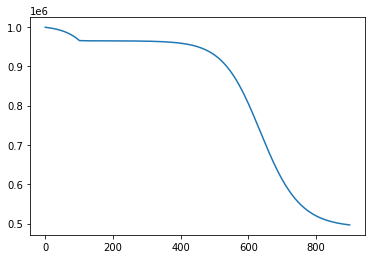

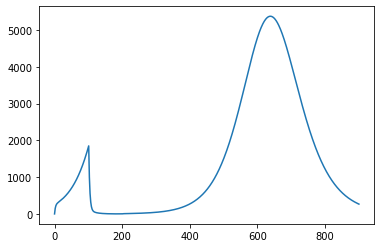

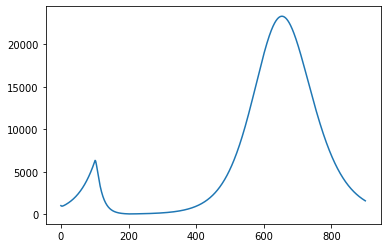

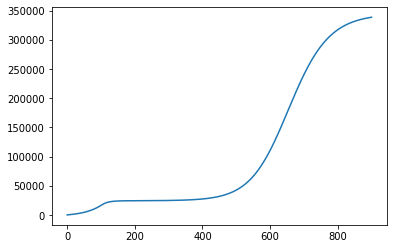

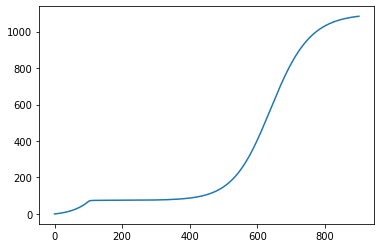

In [ ]:
import matplotlib.pyplot as plt
# test_cap = 0.001
hygiene = 0.18    #parameters to be infered
distancing = 0.60 # Canada
lockdown = 0.96
quarantine = 0.76 # Korea

hospital_cap = 2* 1/3400
transmission_days = 16.92/2.11
exposed_days = 3.59 
recovery_days = 16.92 
# waning_days = 365

susceptible0 = 0.999
infected0 = 0.001
exposed0 = 0
recovered0 = 0

population = 1000000

def virus_model(days,policy):

  if policy == "hygiene":
    pol = hygiene
  elif policy == "distancing":
    pol = distancing
  elif policy == "lockdown":
    pol = lockdown
  elif policy == "quarantine":
    pol = quarantine
  elif policy == "None":
    pol = None

  transmission_rate = (1/ transmission_days)
  incubation_rate = (1/  exposed_days)
  recovery_rate = (1/ recovery_days)
  # immunity_loss_rate = (1/ waning_days)
  death_rate_with_med = 0.02
  death_rate_without_med = 0.9
  ser_case_rate = 0.15


  r0 = 4.2

  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  re = [r0]
  d = [0]
  testing = 0
  
  for day in range(days):
    if day < 200 and day >100 and pol != None:
      transmission_rate = (1/ transmission_days) * (1-pol)
    else:
      transmission_rate = (1/ transmission_days)
    susceptible -= susceptible * infected * transmission_rate 
    exposed +=  susceptible * infected * transmission_rate
    exposed -= exposed * incubation_rate

    infected += exposed * incubation_rate 
    infected -= infected * recovery_rate

    if (ser_case_rate*exposed * incubation_rate < hospital_cap):
      dead += ser_case_rate*exposed * incubation_rate * death_rate_with_med
      infected -= ser_case_rate*exposed * incubation_rate * death_rate_with_med
    else:
      dead += hospital_cap*death_rate_with_med + (exposed * incubation_rate * ser_case_rate - hospital_cap) * death_rate_without_med
      infected -= hospital_cap*death_rate_with_med + (exposed * incubation_rate * ser_case_rate - hospital_cap) * death_rate_without_med

    recovered += infected * recovery_rate

    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
  
  return susc, exp, inf, rec, d, re

days = 900

result_h = virus_model(days,'hygiene')
result_d = virus_model(days,'distancing')
result_l = virus_model(days,'lockdown')
result_q = virus_model(days,'quarantine')
result = virus_model(days,'None')

m = [m for m in range(days+1)]

plt.plot(m, result_l[0], label="line S")
plt.plot()
plt.show()

plt.plot(m, result_l[1], label="line E")
plt.plot()
plt.show()

plt.plot(m, result_l[2], label="line I")
plt.plot()
plt.show()

plt.plot(m, result_l[3], label="line R")
plt.plot()
plt.show()

plt.plot(m, result_l[4], label="line D")
plt.plot()
plt.show()

# plt.plot(m, result[5], label="line Re")
# plt.plot()
# plt.show()